목차

I. 프로젝트 준비과정

II. 프로젝트: 뉴스기사 요약해보기

루브릭 평가 기준

1. Abstractive 모델 구성을 위한 텍스트 전처리 단계가 체계적으로 진행되었다.
  ==> 분석단계, 정제단계, 정규화와 불용어 제거, 데이터셋 분리, 인코딩 과정이 빠짐없이 체계적으로 진행되었다.
2. 텍스트 요약모델이 성공적으로 학습되었음을 확인하였다.

  ==> 모델학습이 안정적으로 수렴되었음을 그래프를 통해 확인하였으며, 실제 요약문과 유사한 요약문장을 얻을 수 있었다.
3. Extractive 요약을 시도해 보고 Abstractive 요약 결과과 함께 비교해 보았다.

  ==> 두 요약 결과를 문법완성도 측면과 핵심단어 포함 측면으로 나누어 비교분석 결과를 제시하였다.
  
소감

오늘 프로젝트는 잘한건지 못한건지 사실 모르겠다.

비슷한 단어들이 나오고는 있지만 학습을 통한방법이나  summarize 방법이나 헤드라인을 맞추기는 힘든것 같다. 

자연어처리에 대해서 좀더 공부를 하면 재미있을것 같다. 단, 한국어로 .....

# 프로젝트 준비과정

## 1. 데이터 준비하기


### 1> 학습에 사용할 데이터셋은 Kaggle에서 제공된 아마존 리뷰 데이터셋

#터미널 
$ mkdir -p ~/aiffel/news_summarization/data

$ ln -s ~/data/*.csv ~/aiffel/news_summarization/data

### 2> NLTK의 불용어(stopwords)를 사용
이 NLTK에는 I, my, me, over, 조사, 접미사와 같이 문장에는 자주 등장하지만, 의미를 분석하고 요약하는 데는 거의 의미가 없는 100여개의 불용어가 미리 정리되어 있다

이를 이용해 다운로드한 리뷰 파일에서 불용어를 제거하는 작업을 진행

In [3]:
import nltk
nltk.download('stopwords')

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')


[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### 3> 다운로드 받은 데이터(Reviews.csv)는 총 568,454개의 샘플을 갖고 있다. 

### 시간상 여기서는 모든 샘플을 사용하지는 않고, 간단히 10만 개의 샘플만 사용한다

In [4]:
data = pd.read_csv(os.getenv("HOME")+"/aiffel/news_summarization/data/Reviews.csv", nrows=100000)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 100000


In [5]:
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [6]:
#  전체 데이터 중 Summary 열과 Text 열만 훈련에 사용할 거라, 이 두 개의 열만 별도로 저장하고, 다시 출력
data = data[['Text','Summary']]
data.head()

#랜덤한 15개 샘플 출력
data.sample(15)

,Text,Summary
46034,I bought 3 bags of this tea and found each to ...,Very poor tea
14656,I have been grinding my own coffee and putting...,really bold taste - the best I have found
74098,The smokey flavor and vinegar come through str...,Heavy on Smoke and Vinegar
82449,I have been using Olive Oil for cooking for se...,Excellent product at an amazing price!
27381,I have fund this dog food to be a extremely go...,Cant Say Enough
48004,"So healthy and good for you, and it tastes gre...",Fantastic
67164,I like buying the Sun Maid Raisins in 12-ounce...,"Perfect size for fresh, good tasting raisins!"
60388,"Great taste, but it seems rather light on the ...","Taste good, but light on the green tea"
96520,This is my favorite tea. No artificial anythi...,Great Tea
46781,This is a great product. I wanted a cocoa powd...,Hershey's Great


==> Text 열의 내용을 요약한 것이 Summary 열. 
여기서는 인공 신경망을 통해 Text 시퀀스를 입력받으면, Summary 시퀀스를 예측하도록 인공 신경망을 훈련시킬 것임

## 2. 데이터 전처리하기 (1) 데이터 정리하기

### 1>중복 샘플과 NULL 값이 존재하는 샘플 제거

In [9]:
# 우선 데이터의 중복 샘플 유무를 확인
print('Text 열에서 중복을 배제한 유일한 샘플의 수 :', data['Text'].nunique())
print('Summary 열에서 중복을 배제한 유일한 샘플의 수 :', data['Summary'].nunique())

Text 열에서 중복을 배제한 유일한 샘플의 수 : 88426
Summary 열에서 중복을 배제한 유일한 샘플의 수 : 72348


==> 이 데이터의 Summary는 'Smelly'나 'Good Product'와 같이 아주 간단한 요약들도 많아서 Text가 달라도 Summary는 동일할 수 있음. 

하지만 Text 자체가 중복이 된 경우는 중복 샘플이므로 제거해야함.

In [10]:
# inplace=True 를 설정하면 DataFrame 타입 값을 return 하지 않고 data 내부를 직접적으로 바꿉니다
data.drop_duplicates(subset = ['Text'], inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 88426


In [11]:
# 데이터 Null 값을 가지는 샘플이 있었다면, drop_duplicates()가 중복된 Null들을 지워주기는 하겠지만, 
#여전히 Null 값 한 개가 어딘가 남아있을 수 있음
print(data.isnull().sum())

Text       0
Summary    1
dtype: int64


In [12]:
# 데이터프레임에서 Null을 제거할 때는 dropna() 함수를 사용
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 88425


### 2> 텍스트 정규화와 불용어 제거

단어들 중에서는 같은 의미인데도 다른 표현으로 쓰여 마치 다른 단어들처럼 간주되는 경우가 있다 ==> 텍스트 정규화로 해결

In [15]:
# 텍스트 정규화를 위한 사전(dictionary)을 아래와 같이 구성
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


일반적으로 텍스트에는 자주 등장하지만 자연어 처리를 할 때 실질적으로 별 도움이 되지 않는 단어들이 존재

이를 불용어(stopwords)라고 부른다. 

때로는 불용어를 제거하는 것이 자연어 처리의 성능을 높이는 방법. 

여기서는 NLTK에서 제공하는 불용어 리스트를 참조해, 샘플에서 불용어를 제거

In [16]:
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

이 작업 외에도 모든 영어 문자는 소문자로 만들고, 섞여있는 html 태그를 제거하고, 정규 표현식을 통해 각종 특수문자를 제거해서 정말 필요한 내용만 잘 학습할 수 있도록 처리할 것

In [17]:
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens


In [18]:
clean_text = []
# 전체 Text 데이터에 대한 전처리 : 10분 이상 시간이 걸릴 수 있습니다. 
for s in data['Text']:
    clean_text.append(preprocess_sentence(s))

# 전처리 후 출력
print("Text 전처리 후 결과: ", clean_text[:5])

Text 전처리 후 결과:  ['bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better', 'product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo', 'confection around centuries light pillowy citrus gelatin nuts case filberts cut tiny squares liberally coated powdered sugar tiny mouthful heaven chewy flavorful highly recommend yummy treat familiar story lewis lion witch wardrobe treat seduces edmund selling brother sisters witch', 'looking secret ingredient robitussin believe found got addition root beer extract ordered made cherry soda flavor medicinal', 'great taffy great price wide assortment yummy taffy delivery quick taffy lover deal']


In [19]:
clean_summary = []
# 전체 Summary 데이터에 대한 전처리 : 5분 이상 시간이 걸릴 수 있습니다. 
for s in data['Summary']:
    clean_summary.append(preprocess_sentence(s, False))

print("Summary 전처리 후 결과: ", clean_summary[:5])

Summary 전처리 후 결과:  ['good quality dog food', 'not as advertised', 'delight says it all', 'cough medicine', 'great taffy']


==> 이렇게 텍스트 정제의 과정을 거친 후에는 다시 한번 빈(empty) 샘플이 생겼는지 확인하기. 

정제 전에는 데이터가 존재했지만, 정제 과정에서 문장의 모든 단어가 사라지는 경우가 있음 

In [20]:
data['Text'] = clean_text
data['Summary'] = clean_summary

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)


In [21]:
data.isnull().sum()

Text        0
Summary    70
dtype: int64

In [22]:
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 88355


## 3. 데이터 전처리하기 (2) 훈련데이터와 테스트데이터 나누기

### 1> 샘플의 최대 길이 정하기
이제 훈련에 사용할 샘플의 최대 길이를 정해줄 차례

텍스트의 최소 길이 : 2
텍스트의 최대 길이 : 1235
텍스트의 평균 길이 : 38.792428272310566
요약의 최소 길이 : 1
요약의 최대 길이 : 28
요약의 평균 길이 : 4.010729443721352


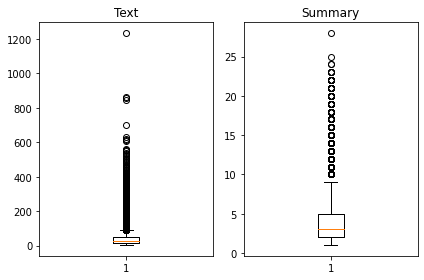

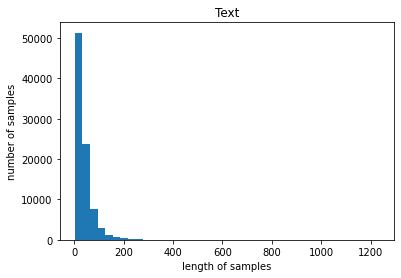

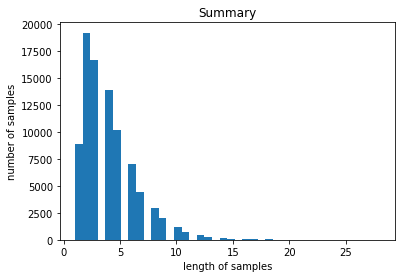

In [24]:
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['Text']]
summary_len = [len(s.split()) for s in data['Summary']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(summary_len)))
print('요약의 최대 길이 : {}'.format(np.max(summary_len)))
print('요약의 평균 길이 : {}'.format(np.mean(summary_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('Text')
plt.subplot(1,2,2)
plt.boxplot(summary_len)
plt.title('Summary')
plt.tight_layout()
plt.show()

plt.title('Text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Summary')
plt.hist(summary_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

Text의 경우 최소 길이가 2, 최대 길이가 1,235로 그 차이가 굉장히 큼. 

하지만 평균 길이는 38로 시각화된 그래프로 봤을 때는 대체적으로는 100 내외의 길이를 가진다는 것을 확인

Summary의 경우 최소 길이가 1, 최대 길이가 28, 그리고 평균 길이가 4로 Text에 비해 상대적으로 길이가 매우 짧음

그래프로 봤을 때에도 대체적으로 10이하의 길이를 가지고 있네요.

이로부터 Text의 최대 길이와 Summary의 적절한 최대 길이를 임의로 정해보기

In [27]:
text_max_len = 50
summary_max_len = 8


==> 얼마나 많은 샘플들을 자르지 않고 포함할 수 있는지 통계로 확인하는 편이 객관적으로 길이를 결정하는 데 도움이 됨. 

훈련 데이터와 샘플의 길이를 입력하면, 데이터의 몇 %가 해당하는지 계산하는 함수를 만들어서 좀 더 정확하게 판단

In [29]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))


In [30]:
below_threshold_len(text_max_len, data['Text'])
below_threshold_len(summary_max_len,  data['Summary'])

전체 샘플 중 길이가 50 이하인 샘플의 비율: 0.7745119121724859
전체 샘플 중 길이가 8 이하인 샘플의 비율: 0.9424593967517402


==> 각각 50과 8로 패딩을 하게 되면 해당 길이보다 긴 샘플들은 내용이 잘리게 되는데, 

Text 열의 경우에는 약 23%의 샘플들이 내용이 망가지게 된다고 하네요.

우리는 정해진 길이에 맞춰 자르는 것이 아니라, 정해진 길이보다 길면 제외하는 방법으로 데이터를 정제

In [32]:
data = data[data['Text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['Summary'].apply(lambda x: len(x.split()) <= summary_max_len)]
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 65818


### 2> 시작 토큰과 종료 토큰 추가하기
디코더는 시작 토큰을 입력받아 문장을 생성하기 시작하고, 종료 토큰을 예측한 순간에 문장 생성을 멈추는 것

seq2seq 훈련을 위해서는 디코더의 입력과 레이블에 시작 토큰과 종료 토큰을 추가할 필요가 있어요. 

이번 실습에서는 시작 토큰은 sostoken, 종료 토큰은 eostoken이라 임의로 명명하고 앞, 뒤로 추가할 거예요.

디코더의 입력에 해당하면서 시작 토큰이 맨 앞에 있는 문장의 이름을 decoder_input, 
디코더의 출력 또는 레이블에 해당되면서 종료 토큰이 맨 뒤에 붙는 문장의 이름을 decoder_target이라고 이름을 정했어요. 

두 개의 문장 모두 Summary 열로부터 만들 거예요.

In [33]:
# 요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['Summary'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['Summary'].apply(lambda x : x + ' eostoken')
data.head()

,Text,Summary,decoder_input,decoder_target
0,bought several vitality canned dog food produc...,good quality dog food,sostoken good quality dog food,good quality dog food eostoken
1,product arrived labeled jumbo salted peanuts p...,not as advertised,sostoken not as advertised,not as advertised eostoken
2,confection around centuries light pillowy citr...,delight says it all,sostoken delight says it all,delight says it all eostoken
3,looking secret ingredient robitussin believe f...,cough medicine,sostoken cough medicine,cough medicine eostoken
4,great taffy great price wide assortment yummy ...,great taffy,sostoken great taffy,great taffy eostoken


In [34]:
encoder_input = np.array(data['Text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블


### 3> 훈련 데이터와 테스트 데이터를 분리

In [35]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[15068 23766 45832 ... 50781 55236 50477]


In [36]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]


In [37]:
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 13163


In [38]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 52655
훈련 레이블의 개수 : 52655
테스트 데이터의 개수 : 13163
테스트 레이블의 개수 : 13163


==> 훈련 데이터와 테스트 데이터가 각각 52,655개와 13,163개로 잘 분리된 것을 볼 수 있어요!



## 4.데이터 전처리하기 (3) 정수 인코딩

### 1> 단어 집합(vocabulary) 만들기 및 정수 인코딩
이제 기계가 텍스트를 숫자로 처리할 수 있도록 훈련 데이터와 테스트 데이터의 단어들을 모두 정수로 바꾸어 주어야 해요. 

이를 위해서는 각 단어에 고유한 정수를 맵핑하는 작업이 필요해요. 

이 과정을 단어 집합(vocabulary) 을 만든다고 표현

In [42]:
# Keras의 토크나이저를 사용하면, 입력된 훈련 데이터로부터 단어 집합을 만들 수 있어요
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성


==>이제 단어 집합이 생성되는 동시에 각 단어에 고유한 정수가 부여되었어요. 

현재 생성된 단어 집합은 src_tokenizer.word_index에 저장되어 있어요. 

그런데 우리는 이렇게 만든 단어 집합에 있는 모든 단어를 사용하는 것이 아니라, 빈도수가 낮은 단어들은 훈련 데이터에서 제외하고 진행

src_tokenizer.word_counts.items()에는 단어와 각 단어의 등장 빈도수가 저장돼 있는데, 이를 통해서 통계적인 정보를 얻을 수 있어요.

In [44]:
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 31964
등장 빈도가 6번 이하인 희귀 단어의 수: 23732
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 8232
단어 집합에서 희귀 단어의 비율: 74.24602678012764
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.3993677904109365


==> 그래서 등장 빈도가 6회 이하인 단어들은 정수 인코딩 과정에서 빼고, 훈련 데이터에서 제거하고자 합니다. 

위에서 이를 제외한 단어 집합의 크기를 8천여 개로 계산했는데, 이와 비슷한 값으로 어림잡아 단어 집합의 크기를 8,000으로 제한해볼게요. 

토크나이저를 정의할 때 num_words의 값을 정해주면, 단어 집합의 크기를 제한할 수 있어요.

In [45]:
src_vocab = 8000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 8,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성


In [46]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[36, 8, 2411, 6421, 18, 900, 700, 8, 27, 883, 2366, 153, 2545, 232, 4, 456, 269, 237, 330, 46, 1783, 95, 8, 4787, 1251, 94, 17], [41, 104, 4, 1492, 7197, 139, 2, 15, 13, 795], [24, 3173, 50, 20, 202, 3173, 306, 110, 914, 399, 24, 380, 690, 394, 96, 3173, 232, 529, 53, 1034, 9, 94, 30, 190, 71]]


### Summary 데이터에 대해서도 동일한 작업을 수행


In [47]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

tar_vocab = 2000
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

단어 집합(vocabulary)의 크기 : 10503
등장 빈도가 5번 이하인 희귀 단어의 수: 8127
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 2376
단어 집합에서 희귀 단어의 비율: 77.37789203084833
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 5.8965677659464495
input
input  [[1, 237, 3], [1, 58], [1, 17, 195], [1, 625, 6, 5, 395, 157, 110], [1, 61, 230, 99, 52, 63, 1015, 1968]]
target
decoder  [[237, 3, 2], [58, 2], [17, 195, 2], [625, 6, 5, 395, 157, 110, 2], [61, 230, 99, 52, 63, 1015, 1968, 2]]


훈련 데이터와 테스트 데이터에 대해서 요약문의 길이가 1인 경우의 인덱스를 각각 drop_train과 drop_test에 라는 변수에 저장해볼게요. 
이 샘플들은 모두 삭제할 거예요.

In [48]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 1279
삭제할 테스트 데이터의 개수 : 313
훈련 데이터의 개수 : 51376
훈련 레이블의 개수 : 51376
테스트 데이터의 개수 : 12850
테스트 레이블의 개수 : 12850


### 2> 패딩하기

텍스트 시퀀스를 정수 시퀀스로 변환했다면, 이제 서로 다른 길이의 샘플들을 병렬 처리하기 위해 같은 길이로 맞춰주는 패딩 작업을 해주어야 해야 해요. 

아까 정해두었던 최대 길이로 패딩 해 줄 거에요. 

최대 길이보다 짧은 데이터들은 뒤의 공간에 숫자 0을 넣어 최대 길이로 길이를 맞춰줄게요.

In [50]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=summary_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=summary_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=summary_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=summary_max_len, padding='post')


## 5.모델 설계하기

In [51]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

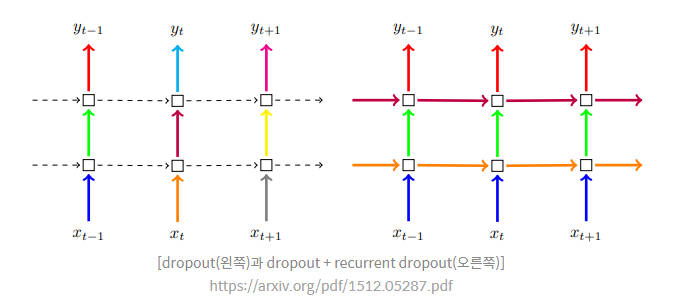

In [53]:

# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

In [54]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 50, 128)      1024000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 50, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

 ==> 지금까지 설계한 것은 인코더의 hidden state와 cell state를 디코더의 초기 state로 사용하는 가장 기본적인 seq2seq에요. 
    그런데 디코더의 출력층을 설계를 살짝 바꿔서 성능을 높일 수 있는 방법이 있어요! 
 ###  바로 어텐션 메커니즘이에요.

In [55]:
from tensorflow.keras.layers import AdditiveAttention

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])


# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 50, 128)      1024000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 50, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

==> 위의 코드는 인코더의 hidden state들과 디코더의 hidden state들을 어텐션 함수의 입력으로 사용하고, 
어텐션 함수가 리턴한 값을 예측 시에 디코더의 hidden state와 함께 활용하는 형태로 작동하고 있어요.

## 6. 모델 훈련하기

In [56]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
201/201 [==============================] - 201s 942ms/step - loss: 2.7031 - val_loss: 2.4087
Epoch 2/50
201/201 [==============================] - 190s 946ms/step - loss: 2.3623 - val_loss: 2.2771
Epoch 3/50
201/201 [==============================] - 186s 925ms/step - loss: 2.2248 - val_loss: 2.1503
Epoch 4/50
201/201 [==============================] - 186s 928ms/step - loss: 2.1073 - val_loss: 2.0740
Epoch 5/50
201/201 [==============================] - 184s 913ms/step - loss: 2.0267 - val_loss: 2.0145
Epoch 6/50
201/201 [==============================] - 181s 902ms/step - loss: 1.9648 - val_loss: 1.9830
Epoch 7/50
201/201 [==============================] - 182s 904ms/step - loss: 1.9144 - val_loss: 1.9451
Epoch 8/50
201/201 [==============================] - 183s 911ms/step - loss: 1.8706 - val_loss: 1.9242
Epoch 9/50
201/201 [==============================] - 182s 905ms/step - loss: 1.8300 - val_loss: 1.9082
Epoch 10/50
201/201 [==============================] - 181s 899m

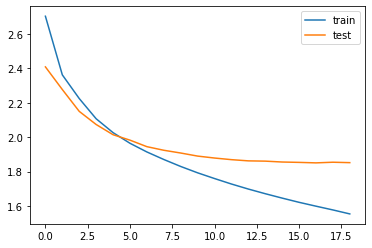

In [57]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

### ===> 1시간 넘게 걸림 ㅠㅠ

## 7. 인퍼런스 모델 구현하기
테스트 단계에서는 정수 인덱스 행렬로 존재하던 텍스트 데이터를 실제 데이터로 복원해야 하므로, 필요한 3개의 사전을 아래와 같이 미리 준비

In [58]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음


훈련 단계에서는 디코더의 입력부에 정답이 되는 문장 전체를 한꺼번에 넣고 디코더의 출력과 한 번에 비교할 수 있으므로, 

인코더와 디코더를 엮은 통짜 모델 하나만 준비했습니다.

그러나 정답 문장이 없는 인퍼런스 단계에서는 만들어야 할 문장의 길이만큼 디코더가 반복 구조로 동작해야 하기 때문에 

부득이하게 인퍼런스를 위한 모델 설계를 별도로 해주어야 합니다. 이때는 인코더 모델과 디코더 모델을 분리해서 설계합니다.

In [59]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])



어텐션 메커니즘을 사용하는 출력층을 설계해 주세요.

In [60]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])



인퍼런스 단계에서 단어 시퀀스를 완성하는 함수를 만들어주세요.

In [61]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (summary_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence


## 8. 모델 테스트하기

테스트 단계에서는 정수 시퀀스를 텍스트 시퀀스로 변환하여 결과를 확인하는 것이 편하겠죠. 

주어진 정수 시퀀스를 텍스트 시퀀스로 변환하는 함수를 만들어볼게요. 

함수를 만들 때, Text의 정수 시퀀스에서는 패딩을 위해 사용되는 숫자 0을 제외하고 Summary의 정수 시퀀스에서는 숫자 0, 시작 토큰의 인덱스, 종료 토큰의 인덱스를 출력에서 제외하도록 만들 거예요.

In [63]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if ((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp



테스트 데이터 약 50개의 샘플에 대해서 실제 요약과 예측된 요약을 비교해보세요.

In [64]:
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : son loves taste much wants eat every meal want give six stars 
실제 요약 : want to give it six stars 
예측 요약 :  my son loves this


원문 : quest perfect homemade wings sauce could come using different recipes bought sauce great use wing coating gives outside wings kind texture get real 
실제 요약 : great sauce 
예측 요약 :  great sauce


원문 : loved chips even teenager loved things got salt pepper first order ordered variety package really looking forward trying others 
실제 요약 : great chips 
예측 요약 :  great chips


원문 : pasta always consistantly good pasta buy pastas quality always consistantly good 
실제 요약 : delicious 
예측 요약 :  great pasta


원문 : ordered bag coffee get order free shipping ever order hardly even par grocery store stuff little stale smelling sure peet coffee course peet costs fortune 
실제 요약 : none too good 
예측 요약 :  stale


원문 : cannot keep enough treats house glad discovered dog 
실제 요약 : dog loves chicken 
예측 요약 :  great for training


원문 : tried many cup coffees newman extra bold o

==> 많은 결과가 출력이 되는데, 기존의 요약과는 다른 요약을 출력하면서도 원문의 내용을 담고 있는 의미 있는 요약들이 보이네요. 
심지어 일부 요약의 경우에는 원문에 없던 단어를 사용해서 요약을 하기도 하고 있어요. 워드 임베딩과 RNN의 콜라보로 이뤄낸 신기한 성과네요!

물론 슬프게도 그다지 좋지 않은 요약의 예도 꽤나 보이기도 하네요. 성능을 개선하기 위해서는 

seq2seq와 어텐션의 자체의 조합을 좀 더 좋게 수정하는 방법도 있고, 

빔 서치(beam search), 사전 훈련된 워드 임베딩(pre-trained word embedding), 

또는 인코더 - 디코더 자체의 구조를 새로이 변경한 하는 트랜스포머(Transformer)와 같은 여러 개선 방안들이 존재합니다. 

이런 방안들에 대해서도 향후 살펴보게 될 것입니다.

## 9. 추출적 요약 해보기
앞서 seq2seq를 통해서 추상적 요약을 진행해봤어요. 

그런데 텍스트 요약에는 추상적 요약 외에도 이미 본문에 존재하는 단어구, 문장을 뽑아서 요약으로 삼는 추출적 요약 방법도 있었죠.

$ pip list | grep summa

## 1> 데이터 다운로드하기

In [66]:
import requests
from summa.summarizer import summarize

In [67]:
text = requests.get('http://rare-technologies.com/the_matrix_synopsis.txt').text

In [68]:
print(text[:1500])

The screen is filled with green, cascading code which gives way to the title, The Matrix.

A phone rings and text appears on the screen: "Call trans opt: received. 2-19-98 13:24:18 REC: Log>" As a conversation takes place between Trinity (Carrie-Anne Moss) and Cypher (Joe Pantoliano), two free humans, a table of random green numbers are being scanned and individual numbers selected, creating a series of digits not unlike an ordinary phone number, as if a code is being deciphered or a call is being traced.

Trinity discusses some unknown person. Cypher taunts Trinity, suggesting she enjoys watching him. Trinity counters that "Morpheus (Laurence Fishburne) says he may be 'the One'," just as the sound of a number being selected alerts Trinity that someone may be tracing their call. She ends the call.

Armed policemen move down a darkened, decrepit hallway in the Heart O' the City Hotel, their flashlight beam bouncing just ahead of them. They come to room 303, kick down the door and find a

## 2> summarize 사용하기
Summa의 summarize는 문장 토큰화를 별도로 하지 않더라도 내부적으로 문장 토큰화를 수행해요. 

그렇기 때문에 문장 구분이 되어있지 않은 원문을 바로 입력으로 넣을 수 있어요. 

비율을 적게 주어서 요약문으로 선택되는 문장의 개수를 줄여볼게요. 원문의 0.005%만을 출력하도록 설정했어요.

In [69]:
print('Summary:')
print(summarize(text, ratio=0.005))

Summary:
Morpheus, Trinity, Neo, Apoc, Switch, Mouse and Cypher are jacked into the Matrix.
Trinity brings the helicopter down to the floor that Morpheus is on and Neo opens fire on the three Agents.


In [70]:
#리스트로 출력 결과를 받고 싶다면 split 인자의 값을 True로 하면 돼요.

print('Summary:')
print(summarize(text, ratio=0.005, split=True))

Summary:
['Morpheus, Trinity, Neo, Apoc, Switch, Mouse and Cypher are jacked into the Matrix.', 'Trinity brings the helicopter down to the floor that Morpheus is on and Neo opens fire on the three Agents.']


In [71]:
#단어의 수로 요약문의 크기를 조절할 수도 있어요. 단어를 50개만 선택하도록 해보세요.
print('Summary:')
print(summarize(text, words=50))

Summary:
Trinity takes Neo to Morpheus.
Morpheus, Trinity, Neo, Apoc, Switch, Mouse and Cypher are jacked into the Matrix.
Trinity brings the helicopter down to the floor that Morpheus is on and Neo opens fire on the three Agents.


# 프로젝트: 뉴스기사 요약해보기

## Step 1. 데이터 수집하기

In [4]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [5]:
data.sample(10)

,headlines,text
10202,SA duo become first married pair to bat togeth...,South Africa captain Dane van Niekerk and her ...
48583,Railways seeks to block 19 sites over ticket s...,The Indian Railways has asked the IT Ministry ...
69000,Sweeper held for molesting 9-year-old girl in ...,The police on Friday arrested a 22-year-old sw...
51986,9 killed as under-construction bridge collapse...,At least nine construction workers were killed...
74080,Feminism is not about asking for reservation: ...,Actress Taapsee Pannu has said that feminism i...
64437,RBI forms 10-member task force on Public Credi...,The RBI has announced a 10-member task force t...
85397,India's retail inflation hits record low of 2....,India's retail inflation in May cooled to a re...
4496,Not tiny firm taken over by big one: Twinkle o...,Actress Twinkle Khanna has said that she did n...
59810,US likens its relationship with Turkey to 'mar...,The relationship between the US and Turkey are...
30818,Wife beats up American golfer for not performi...,Former US Open golf champion Lucas Glover's wi...


###  추상적 요약을 하는 경우에는 text를 본문, headlines를 이미 요약된 데이터로 삼아서 모델을 학습할 수 있어요. 
### 추출적 요약을 하는 경우에는 오직 text열만을 사용하세요.

In [6]:
import nltk
nltk.download('stopwords')

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
print('전체 샘플 수 : ', len(data))

전체 샘플 수 :  98401


In [8]:
print(data['headlines'][0])  # 요약본
print(data['text'][0])  # 기사

upGrad learner switches to career in ML & Al with 90% salary hike
Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers.


## Step 2. 데이터 전처리하기 (추상적 요약)

실습에서 사용된 전처리를 참고하여 각자 필요하다고 생각하는 전처리를 추가 사용하여 텍스트를 정규화 또는 정제해 보세요. 

만약, 불용어 제거를 선택한다면 상대적으로 길이가 짧은 요약 데이터에 대해서도 불용어를 제거하는 것이 좋을지 고민해 보세요.

### 1> 중복 샘플과 NULL 값이 존재하는 샘플 제거 

In [9]:
# 우선 데이터의 중복 샘플 유무를 확인
print('Text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())
print('Headlines 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())

Text 열에서 중복을 배제한 유일한 샘플의 수 : 98360
Headlines 열에서 중복을 배제한 유일한 샘플의 수 : 98280


In [10]:
#drop_duplicates()를 사용하면 중복 제거
data.drop_duplicates(subset = ['text'], inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


==> 중복이 없다 ^^

### 2> 텍스트 정규화와 불용어 제거

In [11]:
# 텍스트 정규화를 위한 사전(dictionary)을 아래와 같이 구성
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


In [12]:
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

In [13]:
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

In [14]:
clean_text = []
# 전체 Text 데이터에 대한 전처리 : 10분 이상 시간이 걸릴 수 있습니다. 
for s in data['text']:
    clean_text.append(preprocess_sentence(s))

# 전처리 후 출력
print("Text 전처리 후 결과: ", clean_text[:5])

Text 전처리 후 결과:  ['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers', 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit', 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history', 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insur

In [17]:
clean_headlines = []
# 전체 headlines 데이터에 대한 전처리 : 5분 이상 시간이 걸릴 수 있습니다. 
for s in data['headlines']:
    clean_headlines.append(preprocess_sentence(s, False))

print("Summary 전처리 후 결과: ", clean_headlines[:5])

Summary 전처리 후 결과:  ['upgrad learner switches to career in ml al with salary hike', 'delhi techie wins free food from swiggy for one year on cred', 'new zealand end rohit sharma led india match winning streak', 'aegon life iterm insurance plan helps customers save tax', 'have known hirani for yrs what if metoo claims are not true sonam']


In [18]:
# 다시한번 빈(empty) 샘플이 생겼는지 확인
data["text"] = clean_text
data["headlines"] = clean_headlines

data.replace('' , np.nan, inplace = True)
data.isnull().sum()

headlines    0
text         0
dtype: int64

### 3> 훈련데이터와 테스트데이터 나누기

### 3-1> 1샘플의 최대 길이 정하기


텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221
요약의 최소 길이 : 1
요약의 최대 길이 : 16
요약의 평균 길이 : 9.299532330215534


NameError: name 'summary_len' is not defined

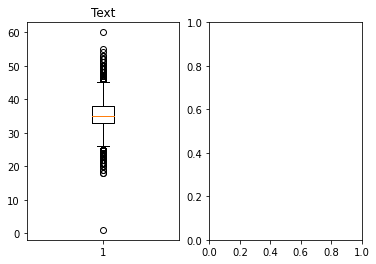

In [19]:
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
headlines_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(headlines_len)))
print('요약의 최대 길이 : {}'.format(np.max(headlines_len)))
print('요약의 평균 길이 : {}'.format(np.mean(headlines_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('Text')
plt.subplot(1,2,2)
plt.boxplot(summary_len)
plt.title('Headlines')
plt.tight_layout()
plt.show()

plt.title('Text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Headlines')
plt.hist(summary_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [20]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))


In [30]:
text_max_len = 45
headlines_max_len = 8
below_threshold_len(text_max_len, data['text'])
below_threshold_len(headlines_max_len, data['headlines'])

전체 샘플 중 길이가 45 이하인 샘플의 비율: 1.0
전체 샘플 중 길이가 8 이하인 샘플의 비율: 1.0


In [31]:
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 25130


In [32]:
data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['headlines'].apply(lambda x: len(x.split()) <= headlines_max_len)]
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 25130


### 3-2> 시작 토큰과 종료 토큰 추가하기

In [33]:
# headlines 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
19,odisha cm patnaik controls mining mafia union ...,union minister dharmendra pradhan wednesday cl...,sostoken odisha cm patnaik controls mining maf...,odisha cm patnaik controls mining mafia union ...
21,isro unveils bengaluru centre for manned space...,indian space research organisation wednesday u...,sostoken isro unveils bengaluru centre for man...,isro unveils bengaluru centre for manned space...
22,killed injured in saudi arabia floods,least people killed others injured saudi arabi...,sostoken killed injured in saudi arabia floods,killed injured in saudi arabia floods eostoken
29,seat cushions from missing plane carrying foot...,investigators searching lost plane carrying ar...,sostoken seat cushions from missing plane carr...,seat cushions from missing plane carrying foot...
36,agustawestland scam accused rajiv saxena extra...,agustawestland chopper scam co accused rajiv s...,sostoken agustawestland scam accused rajiv sax...,agustawestland scam accused rajiv saxena extra...


In [34]:
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

### 3-3> 훈련 데이터와 테스트 데이터를 분리

In [35]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[ 1455   349  5784 ... 14534  2162 24406]


In [36]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]


In [37]:
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 5026


In [38]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 20104
훈련 레이블의 개수 : 20104
테스트 데이터의 개수 : 5026
테스트 레이블의 개수 : 5026


## 4> 정수 인코딩 

### 4-1> 단어 집합(vocabulary) 만들기 및 정수 인코딩

In [39]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성


In [41]:
threshold = 6
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 40355
등장 빈도가 5번 이하인 희귀 단어의 수: 28142
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 12213
단어 집합에서 희귀 단어의 비율: 69.73609218188577
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 7.649368847779578


In [42]:
src_vocab = 8000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 8,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성


In [43]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[1533, 811, 569, 2010, 573, 216, 501, 4475, 172, 1101, 469, 439, 540, 59, 636, 1376, 7312, 620, 6350, 4, 88, 357, 187, 3689, 540, 2060, 2061, 4475, 845], [85, 127, 7, 265, 1199, 2036, 5831, 1296, 296, 2036, 609, 36, 7, 355, 1862, 1296, 6967, 6351, 129, 1, 821, 153, 1102, 2036, 609, 7, 1981, 8, 1], [2919, 2281, 1, 1, 3040, 380, 2393, 3430, 2393, 2120, 1548, 1, 822, 6968, 4, 380, 1, 6, 54, 380, 342, 2857, 342]]


In [44]:
# headlines 데이터에서 실행 

tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)



In [45]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)



단어 집합(vocabulary)의 크기 : 18156
등장 빈도가 5번 이하인 희귀 단어의 수: 13752
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 4404
단어 집합에서 희귀 단어의 비율: 75.743555849306
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 14.596318223117299


In [46]:
tar_vocab = 3000
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])



input
input  [[1, 490, 248, 2609, 748, 1485, 2386], [1, 11, 1084, 2856, 3, 1792, 513], [1, 468, 877, 1222], [1, 1679, 1486, 913, 11, 12], [1, 127, 1402, 12, 1927, 984]]
target
decoder  [[490, 248, 2609, 748, 1485, 2386, 2], [11, 1084, 2856, 3, 1792, 513, 2], [468, 877, 1222, 2], [1679, 1486, 913, 11, 12, 2], [127, 1402, 12, 1927, 984, 2]]


In [50]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 20102
훈련 레이블의 개수 : 20102
테스트 데이터의 개수 : 5024
테스트 레이블의 개수 : 5024


In [51]:
### 4-2> 패팅하기

In [54]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=headlines_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=headlines_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=headlines_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=headlines_max_len, padding='post')

## Step 3. 어텐션 메커니즘 사용하기 (추상적 요약)
일반적인 seq2seq보다는 어텐션 메커니즘을 사용한 seq2seq를 사용하는 것이 더 나은 성능을 얻을 수 있어요. 
실습 내용을 참고하여 어텐션 메커니즘을 사용한 seq2seq를 설계해 보세요.

In [56]:
### 1> 모델 설계하기
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

In [57]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

In [58]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 45)]         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 45, 128)      1024000     input_2[0][0]                    
__________________________________________________________________________________________________
lstm_3 (LSTM)                   [(None, 45, 256), (N 394240      embedding_1[0][0]                
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

In [59]:
from tensorflow.keras.layers import AdditiveAttention

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])


# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 45)]         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 45, 128)      1024000     input_2[0][0]                    
__________________________________________________________________________________________________
lstm_3 (LSTM)                   [(None, 45, 256), (N 394240      embedding_1[0][0]                
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

In [60]:
### 2> 모델 훈련하기
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
79/79 [==============================] - 56s 602ms/step - loss: 5.5981 - val_loss: 5.1304
Epoch 2/50
79/79 [==============================] - 46s 587ms/step - loss: 5.1859 - val_loss: 4.9443
Epoch 3/50
79/79 [==============================] - 47s 595ms/step - loss: 4.9848 - val_loss: 4.8129
Epoch 4/50
79/79 [==============================] - 47s 597ms/step - loss: 4.8276 - val_loss: 4.6759
Epoch 5/50
79/79 [==============================] - 47s 596ms/step - loss: 4.6676 - val_loss: 4.5467
Epoch 6/50
79/79 [==============================] - 47s 596ms/step - loss: 4.5105 - val_loss: 4.4614
Epoch 7/50
79/79 [==============================] - 47s 590ms/step - loss: 4.3717 - val_loss: 4.3790
Epoch 8/50
79/79 [==============================] - 46s 587ms/step - loss: 4.2499 - val_loss: 4.2912
Epoch 9/50
79/79 [==============================] - 47s 593ms/step - loss: 4.1378 - val_loss: 4.2368
Epoch 10/50
79/79 [==============================] - 47s 590ms/step - loss: 4.0304 - val_lo

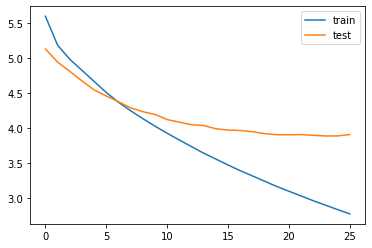

In [61]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

## Step 4. 실제 결과와 요약문 비교하기 (추상적 요약)
원래의 요약문(headlines 열)과 학습을 통해 얻은 추상적 요약의 결과를 비교해 보세요.

### 1>  인퍼런스 모델 구현하기

In [62]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

In [63]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [64]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [72]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (headlines_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

### 2>   모델 테스트하기

In [73]:
### 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2headlines(input_seq):
    temp=''
    for i in input_seq:
        if ((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp


In [97]:
for i in range(1, 11):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2headlines(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : indian railways increased monthly cap tickets booked irctc portal six aadhaar verified passengers move aims encourage passengers link digit unique numbers online booking accounts irctc however passengers continue book six tickets month without aadhaar number 
실제 요약 : aadhaar linked accounts can book tickets month 
예측 요약 :  railways to get delivery of crore


원문 : first female leader japan opposition democratic party resigned thursday party failed pm shinzo abe support defeated tokyo election unable power democratic party become alternative abe cabinet appears administration said 
실제 요약 : first female head of japan opposition party resigns 
예측 요약 :  uk declares election for election


원문 : russian spokesperson said country daily cyber attacks territory us make accusations white house us intelligence agencies notably us repeatedly accused russian hackers meddling last year presidential election donald trump power 
실제 요약 : us based hackers attack us every day russia 
예측 요약 :  russia 

## Step 5. Summa을 이용해서 추출적 요약해보기
추상적 요약은 추출적 요약과는 달리 문장의 표현력을 다양하게 가져갈 수 있지만, 추출적 요약에 비해서 난이도가 높아요. 반대로 말하면 추출적 요약은 추상적 요약에 비해 난이도가 낮고 기존 문장에서 문장을 꺼내오는 것이므로 잘못된 요약이 나올 가능성이 낮아요.

Summa의 summarize를 사용하여 추출적 요약을 해보세요.

In [75]:
### 1> 데이터 다운로드하기
import urllib.request

urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [103]:
import requests
from summa.summarizer import summarize

for id ,(headlines, text) in enumerate(zip(data['headlines'], data['text'] )) :

    if id == 10  :
        break

    print("원문: ",text)
    print("실제 요약 :", headlines)
    print("예측 요약 :", summarize(text, ratio=0.36))
    print("\n")

원문:  Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers.
실제 요약 : upGrad learner switches to career in ML & Al with 90% salary hike
예측 요약 : upGrad's Online Power Learning has powered 3 lakh+ careers.


원문:  Kunal Shah's credit card bill payment platform, CRED, gave users a chance to win free food from Swiggy for one year. Pranav Kaushik, a Delhi techie, bagged this reward after spending 2000 CRED coins. Users get one CRED coin per rupee of bill paid, which can be used to avail rewards from brands like Ixigo, BookMyShow, UberEats, Cult.Fit and more.
실제 요약 : Delhi techie wins free food from Swiggy for one year on CRED
예측 요약 : Users get one CRED coin per rupee of bill pai